In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import scipy

In [2]:
os.getcwd()

'c:\\Users\\Kanishka\\OneDrive\\Desktop\\AI_DermalScan'

In [3]:
dataset = './Dataset'
outputs_path = './Outputs'
def class_distribution(dataset):
    class_num = 1
    labels = []
    counts = []
    for classes in os.listdir(dataset):
        class_path = os.path.join(dataset, classes)
        labels.append(classes)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            counts.append(num_images)
            print(f'Class {class_num}')
            print(f'Class: {classes}')
            print(f'Number of images: {num_images}')
            print('-----------------------')
            class_num += 1
    return labels, counts
labels, counts = class_distribution(dataset)
        

Class 1
Class: clear skin
Number of images: 300
-----------------------
Class 2
Class: dark spots
Number of images: 300
-----------------------
Class 3
Class: puffy eyes
Number of images: 300
-----------------------
Class 4
Class: wrinkles
Number of images: 300
-----------------------


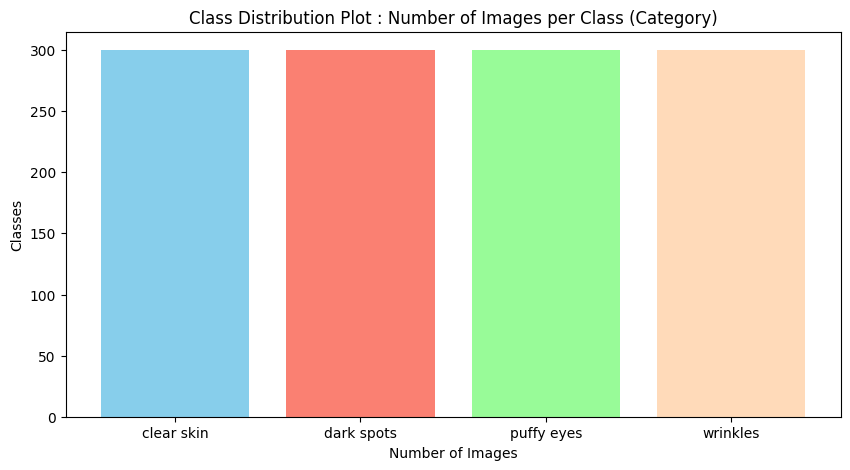

In [4]:
def plot_class_distribution(labels, counts):
    plt.figure(figsize=(10,5))
    plt.bar(labels, counts,color=('skyblue','salmon','palegreen','peachpuff'))
    plt.title('Class Distribution Plot : Number of Images per Class (Category)')
    plt.xlabel('Number of Images')
    plt.ylabel('Classes')
    plt.savefig('Class_Distribution_Plot.png')
    plt.show()
plot_class_distribution(labels, counts)

In [5]:
#This function plots the augmentation scattering per batch

def plot_augmentation_scattering(generator, title="Augmentation Scattering Per Batch"):

    images, labels = next(generator)

    class_indices = np.argmax(labels, axis=1) #to get the class indices from one-hot encoded labels

    # count how many images per class appear in the batch
    unique_classes, counts = np.unique(class_indices, return_counts=True)

    # class names
    class_labels = list(generator.class_indices.keys())

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(class_labels, counts)
    plt.xlabel("Classes")
    plt.ylabel("Images in this batch")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.show()

    return unique_classes, counts

In [6]:
#In this cell a generator object is created for training and validation data augmentation. The rules for augmentation are defined within the ImageDataGenerator function.

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2
)


valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [7]:
#In this cell, the augmentation generator is applied to actual image data from the dataset directory. The images are resized to 224x224 pixels, and the batch size is set to 32. Training and validation subsets are created based on the defined split.(80-20)

img_size = (224, 224)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    dataset,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  #One-hot encoding
    shuffle=True,
    subset='training'
)

valid_generator = valid_datagen.flow_from_directory(
    dataset,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)



Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


One-hot encoded labels:
 [[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


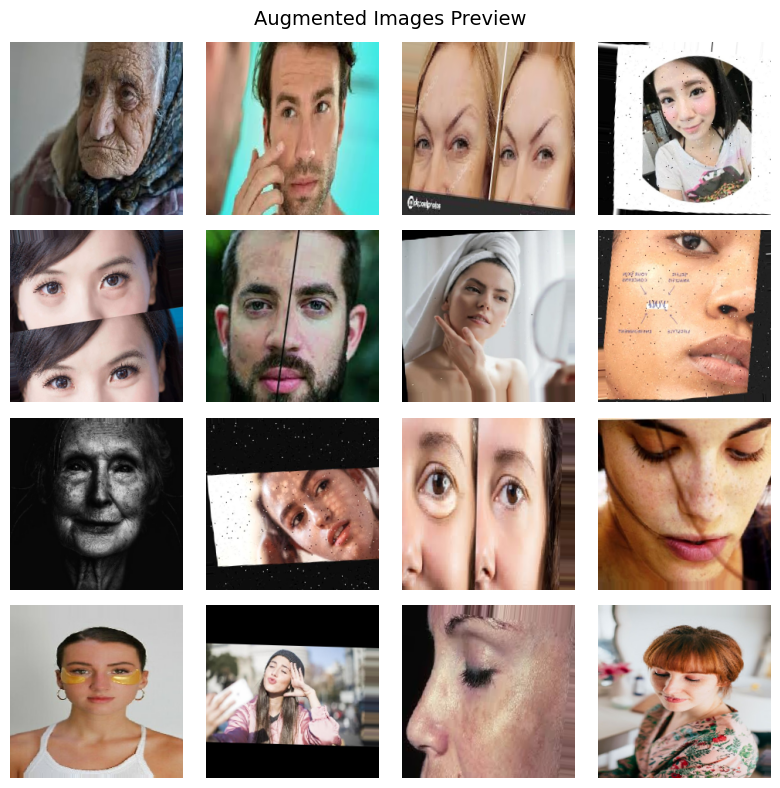

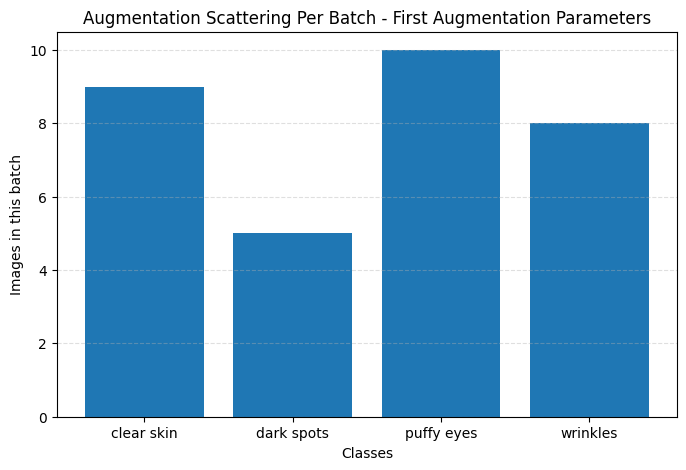

(array([0, 1, 2, 3], dtype=int64), array([ 9,  5, 10,  8], dtype=int64))

In [8]:
#See augmented images using the First augmentation parameters
# Take one batch from train generator
images, labels = next(train_generator)
print("One-hot encoded labels:\n", labels)


plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

plt.suptitle("Augmented Images Preview", fontsize=14)
plt.tight_layout()

# Save the figure
count = len(os.listdir('Outputs'))
filename = f'Outputs/Augmented_Images_{count+1}.png'
plt.savefig(filename)

plt.show()

plot_augmentation_scattering(train_generator, title="Augmentation Scattering Per Batch - First Augmentation Parameters")

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(base_model, num_classes, lr=1e-4, dropout_rate=0.5):

    # Freeze base model
    base_model.trainable = False

    # Custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [10]:
#Plotting function for training history

import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.show()

In [15]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

model = build_model(base_model, train_generator.num_classes)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    callbacks=[early_stop]
)


model.save("EfficientNetB0.h5")


Epoch 1/30
30/30 [==============================] - 28s 729ms/step - loss: 1.4470 - accuracy: 0.2625 - val_loss: 1.3924 - val_accuracy: 0.2500
Epoch 2/30
30/30 [==============================] - 15s 488ms/step - loss: 1.4202 - accuracy: 0.2479 - val_loss: 1.3855 - val_accuracy: 0.2500
Epoch 3/30
30/30 [==============================] - 15s 484ms/step - loss: 1.4176 - accuracy: 0.2438 - val_loss: 1.3856 - val_accuracy: 0.2500
Epoch 4/30
30/30 [==============================] - 14s 478ms/step - loss: 1.4204 - accuracy: 0.2417 - val_loss: 1.3855 - val_accuracy: 0.3167
Epoch 5/30
30/30 [==============================] - 15s 483ms/step - loss: 1.4082 - accuracy: 0.2510 - val_loss: 1.3854 - val_accuracy: 0.2500
Epoch 6/30
30/30 [==============================] - 15s 487ms/step - loss: 1.4086 - accuracy: 0.2688 - val_loss: 1.3854 - val_accuracy: 0.3542
Epoch 7/30
30/30 [==============================] - 15s 486ms/step - loss: 1.4047 - accuracy: 0.2802 - val_loss: 1.3858 - val_accuracy: 0.2500

c:\Users\Kanishka\OneDrive\Desktop\AI_DermalScan\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


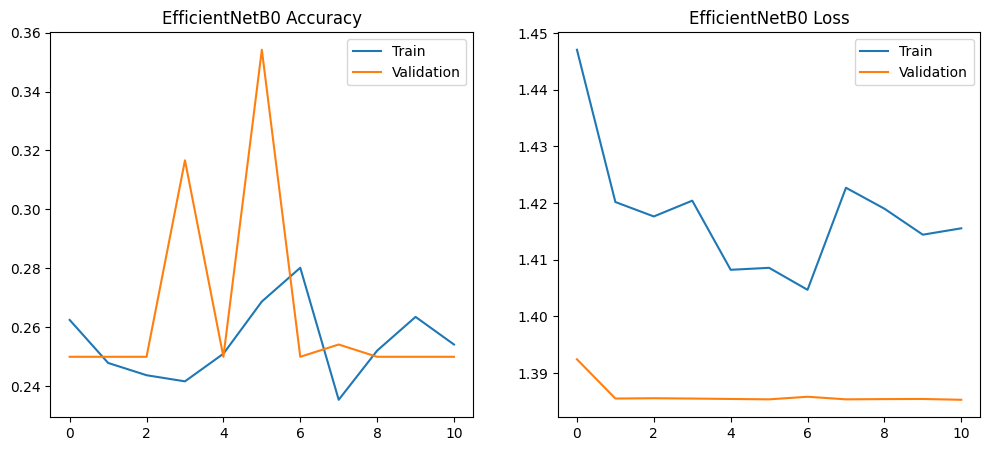

EfficientNetB0 Model training and saving completed.
Validation Accuracy: 0.3541666567325592
Training Accuracy: 0.2802083194255829


In [17]:
plot_history(history, "EfficientNetB0")
print("EfficientNetB0 Model training and saving completed.")
print('Validation Accuracy:', max(history.history['val_accuracy']))
print('Training Accuracy:', max(history.history['accuracy']))

In [19]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

model = build_model(base_model, train_generator.num_classes)

callbacks= [
    EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True
    ),
    ModelCheckpoint(
    filepath="ResNet50_best.h5",  
    monitor="val_accuracy",           
    save_best_only=True,              
    save_weights_only=False,          
    verbose=1
)
]


history_resnet = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    callbacks=callbacks
)

model.save("ResNet50.h5")


Epoch 1/30
30/30 [==============================] - ETA: 0s - loss: 1.7231 - accuracy: 0.2542
Epoch 1: val_accuracy improved from -inf to 0.22500, saving model to ResNet50_best.h5


c:\Users\Kanishka\OneDrive\Desktop\AI_DermalScan\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 34s 1s/step - loss: 1.7231 - accuracy: 0.2542 - val_loss: 1.4028 - val_accuracy: 0.2250
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 1.6782 - accuracy: 0.2417
Epoch 2: val_accuracy did not improve from 0.22500
30/30 [==============================] - 29s 959ms/step - loss: 1.6782 - accuracy: 0.2417 - val_loss: 1.3926 - val_accuracy: 0.1667
Epoch 3/30
30/30 [==============================] - ETA: 0s - loss: 1.6621 - accuracy: 0.2458
Epoch 3: val_accuracy did not improve from 0.22500
30/30 [==============================] - 29s 953ms/step - loss: 1.6621 - accuracy: 0.2458 - val_loss: 1.3878 - val_accuracy: 0.1708
Epoch 4/30
30/30 [==============================] - ETA: 0s - loss: 1.6244 - accuracy: 0.2469
Epoch 4: val_accuracy did not improve from 0.22500
30/30 [==============================] - 29s 952ms/step - loss: 1.6244 - accuracy: 0.2469 - val_loss: 1.3829 - val_accuracy: 0.1875
Epoch 5/30
30/30 [======================

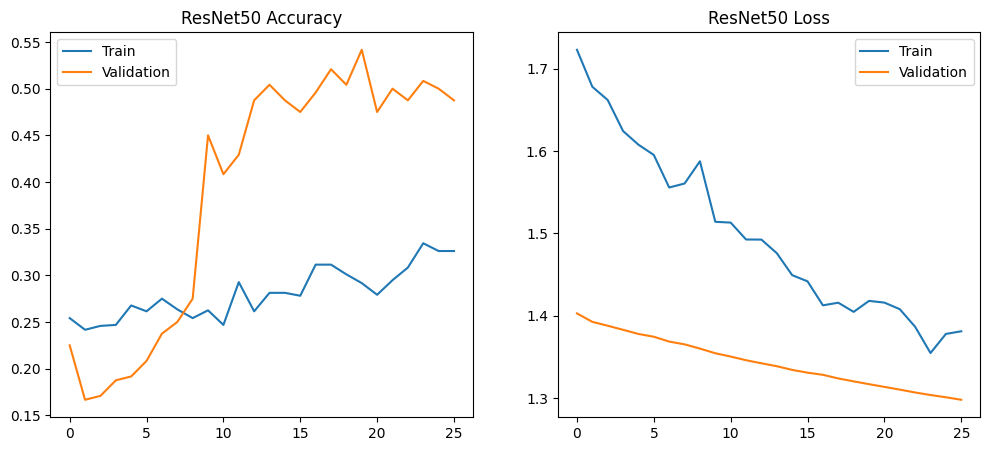

ResNet50 Model training and saving completed.
Validation Accuracy: 0.5416666865348816
Training Accuracy: 0.3343749940395355


In [21]:
plot_history(history_resnet, "ResNet50")
print("ResNet50 Model training and saving completed.")
print('Validation Accuracy:', max(history_resnet.history['val_accuracy']))
print('Training Accuracy:', max(history_resnet.history['accuracy']))

Epoch 1/15
30/30 [==============================] - ETA: 0s - loss: 0.8578 - accuracy: 0.6562
Epoch 1: val_accuracy did not improve from 0.54167
30/30 [==============================] - 57s 2s/step - loss: 0.8578 - accuracy: 0.6562 - val_loss: 2.4280 - val_accuracy: 0.2500
Epoch 2/15
30/30 [==============================] - ETA: 0s - loss: 0.7894 - accuracy: 0.6802
Epoch 2: val_accuracy did not improve from 0.54167
30/30 [==============================] - 45s 1s/step - loss: 0.7894 - accuracy: 0.6802 - val_loss: 2.3714 - val_accuracy: 0.2500
Epoch 3/15
30/30 [==============================] - ETA: 0s - loss: 0.7600 - accuracy: 0.7146
Epoch 3: val_accuracy did not improve from 0.54167
30/30 [==============================] - 44s 1s/step - loss: 0.7600 - accuracy: 0.7146 - val_loss: 2.0201 - val_accuracy: 0.2500
Epoch 4/15
30/30 [==============================] - ETA: 0s - loss: 0.7172 - accuracy: 0.7177
Epoch 4: val_accuracy did not improve from 0.54167
30/30 [==========================

c:\Users\Kanishka\OneDrive\Desktop\AI_DermalScan\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 58s 2s/step - loss: 0.6077 - accuracy: 0.7646 - val_loss: 0.6955 - val_accuracy: 0.7542
Epoch 11/15
30/30 [==============================] - ETA: 0s - loss: 0.5745 - accuracy: 0.7740
Epoch 11: val_accuracy did not improve from 0.75417
30/30 [==============================] - 66s 2s/step - loss: 0.5745 - accuracy: 0.7740 - val_loss: 0.6919 - val_accuracy: 0.7333
Epoch 12/15
30/30 [==============================] - ETA: 0s - loss: 0.5817 - accuracy: 0.7729
Epoch 12: val_accuracy improved from 0.75417 to 0.76667, saving model to ResNet50_best.h5
30/30 [==============================] - 61s 2s/step - loss: 0.5817 - accuracy: 0.7729 - val_loss: 0.5901 - val_accuracy: 0.7667
Epoch 13/15
30/30 [==============================] - ETA: 0s - loss: 0.5811 - accuracy: 0.7771
Epoch 13: val_accuracy did not improve from 0.76667
30/30 [==============================] - 63s 2s/step - loss: 0.5811 - accuracy: 0.7771 - val_loss: 0.7080 - val_accuracy: 0.6833
Epoch

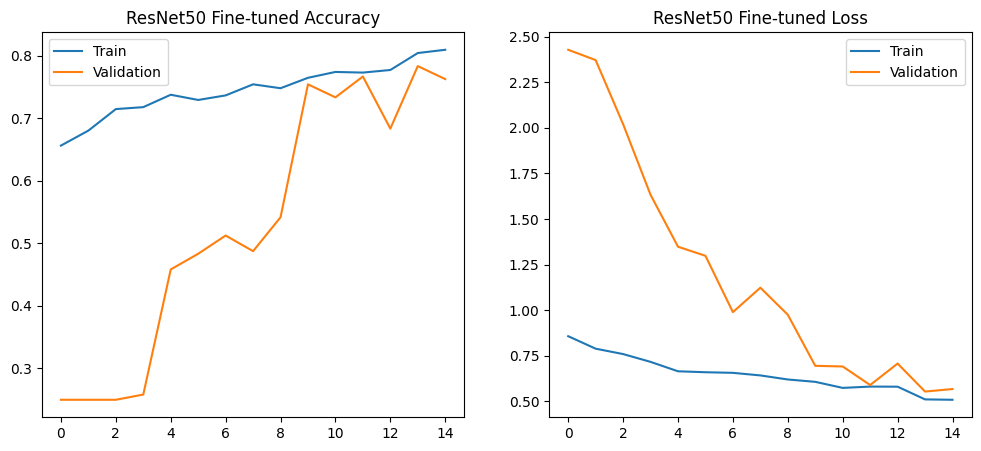

Best ResNet50 Validation Accuracy: 0.7833333611488342


In [26]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-80:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_resnet_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=callbacks
)

plot_history(history_resnet_finetune, "ResNet50 Fine-tuned")
best_resnet_val = max(history_resnet_finetune.history["val_accuracy"])
print("Best ResNet50 Validation Accuracy:", best_resnet_val)


Epoch 1/15
30/30 [==============================] - ETA: 0s - loss: 1.7367 - accuracy: 0.2490
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to VGG16_best.h5
30/30 [==============================] - 66s 2s/step - loss: 1.7367 - accuracy: 0.2490 - val_loss: 1.5644 - val_accuracy: 0.2500
Epoch 2/15
30/30 [==============================] - ETA: 0s - loss: 1.7083 - accuracy: 0.2594
Epoch 2: val_accuracy did not improve from 0.25000
30/30 [==============================] - 85s 3s/step - loss: 1.7083 - accuracy: 0.2594 - val_loss: 1.4935 - val_accuracy: 0.2500
Epoch 3/15
30/30 [==============================] - ETA: 0s - loss: 1.6343 - accuracy: 0.2635
Epoch 3: val_accuracy improved from 0.25000 to 0.25417, saving model to VGG16_best.h5
30/30 [==============================] - 87s 3s/step - loss: 1.6343 - accuracy: 0.2635 - val_loss: 1.4443 - val_accuracy: 0.2542
Epoch 4/15
30/30 [==============================] - ETA: 0s - loss: 1.6263 - accuracy: 0.2365
Epoch 4: val_accu

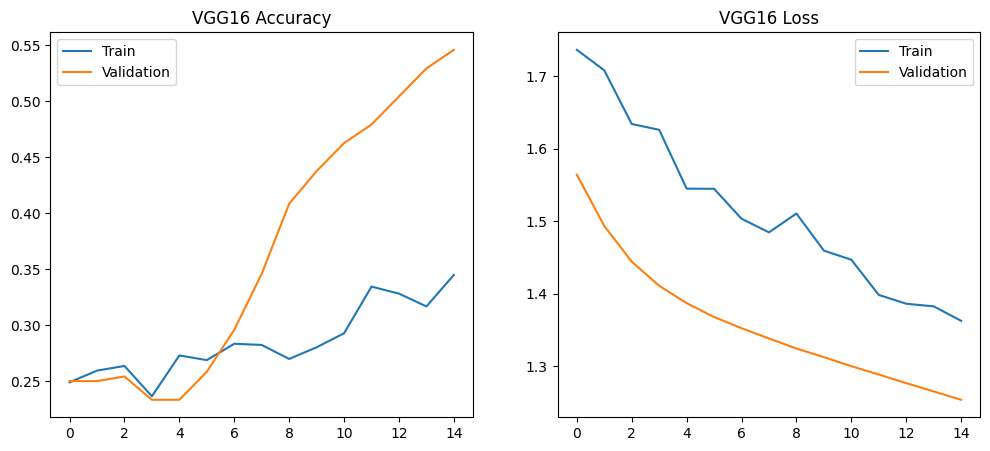

VGG16 Model training and saving completed.
Validation Accuracy: 0.5458333492279053
Training Accuracy: 0.3447916805744171


In [27]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

model = build_model(base_model, train_generator.num_classes)

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True
    ),
    ModelCheckpoint(
    filepath="VGG16_best.h5",  
    monitor="val_accuracy",           
    save_best_only=True,              
    save_weights_only=False,          
    verbose=1
)
]

history_vgg = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=callbacks
)

model.save("VGG16.h5")


plot_history(history_vgg, "VGG16")
print("VGG16 Model training and saving completed.")
print('Validation Accuracy:', max(history_vgg.history['val_accuracy']))
print('Training Accuracy:', max(history_vgg.history['accuracy']))


In [28]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Load pretrained MobileNetV2
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Build model
model = build_model(
    base_model=base_model,
    num_classes=train_generator.num_classes,
    lr=1e-5,
    dropout_rate=0.4
)

# Callbacks for Phase 1
callbacks_phase1 = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True
    ),
    ModelCheckpoint(
    filepath="MobileNetV2_bestmodel.h5",  
    monitor="val_accuracy",           
    save_best_only=True,              
    save_weights_only=False,          
    verbose=1
)
]

# Train (Feature Extraction)
history_phase1 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=callbacks_phase1
)


Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 2.0580 - accuracy: 0.2510
Epoch 1: val_accuracy improved from -inf to 0.25833, saving model to MobileNetV2_bestmodel.h5


c:\Users\Kanishka\OneDrive\Desktop\AI_DermalScan\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 19s 514ms/step - loss: 2.0580 - accuracy: 0.2510 - val_loss: 1.6886 - val_accuracy: 0.2583
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 1.9889 - accuracy: 0.2396
Epoch 2: val_accuracy improved from 0.25833 to 0.27917, saving model to MobileNetV2_bestmodel.h5
30/30 [==============================] - 14s 476ms/step - loss: 1.9889 - accuracy: 0.2396 - val_loss: 1.6344 - val_accuracy: 0.2792
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: 1.9442 - accuracy: 0.2500
Epoch 3: val_accuracy improved from 0.27917 to 0.29167, saving model to MobileNetV2_bestmodel.h5
30/30 [==============================] - 14s 481ms/step - loss: 1.9442 - accuracy: 0.2500 - val_loss: 1.5872 - val_accuracy: 0.2917
Epoch 4/50
30/30 [==============================] - ETA: 0s - loss: 1.9420 - accuracy: 0.2458
Epoch 4: val_accuracy improved from 0.29167 to 0.29583, saving model to MobileNetV2_bestmodel.h5
30/30 [========================

In [29]:
print("Training Phase 1 Results:\n")
best_val_acc = max(history_phase1.history['val_accuracy'])
best_epoch = history_phase1.history['val_accuracy'].index(best_val_acc) + 1
best_train_acc = max(history_phase1.history['accuracy'])
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Epoch: {best_epoch}")
print(f"Best Training Accuracy: {best_train_acc:.4f}")


Training Phase 1 Results:

Best Validation Accuracy: 0.6625
Best Epoch: 50
Best Training Accuracy: 0.5271


In [30]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


base_model.trainable = False

for layer in base_model.layers[:-50]:
    layer.trainable = True


model.compile(
    optimizer=Adam(learning_rate=5e-6), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_finetune = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-6
    ),

    ModelCheckpoint(
    filepath="MobileNetV2_bestmodel2.h5",  
    monitor="val_accuracy",           
    save_best_only=True,              
    save_weights_only=False,          
    verbose=1
)
]

history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=18,
    callbacks=callbacks_finetune
)


Epoch 1/18
30/30 [==============================] - ETA: 0s - loss: 1.5914 - accuracy: 0.3656
Epoch 1: val_accuracy improved from -inf to 0.67917, saving model to MobileNetV2_bestmodel2.h5


c:\Users\Kanishka\OneDrive\Desktop\AI_DermalScan\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 36s 837ms/step - loss: 1.5914 - accuracy: 0.3656 - val_loss: 0.8566 - val_accuracy: 0.6792 - lr: 5.0000e-06
Epoch 2/18
30/30 [==============================] - ETA: 0s - loss: 1.5407 - accuracy: 0.4104
Epoch 2: val_accuracy did not improve from 0.67917
30/30 [==============================] - 23s 765ms/step - loss: 1.5407 - accuracy: 0.4104 - val_loss: 0.8498 - val_accuracy: 0.6792 - lr: 5.0000e-06
Epoch 3/18
30/30 [==============================] - ETA: 0s - loss: 1.4345 - accuracy: 0.4437
Epoch 3: val_accuracy did not improve from 0.67917
30/30 [==============================] - 23s 768ms/step - loss: 1.4345 - accuracy: 0.4437 - val_loss: 0.8430 - val_accuracy: 0.6792 - lr: 5.0000e-06
Epoch 4/18
30/30 [==============================] - ETA: 0s - loss: 1.4341 - accuracy: 0.4229
Epoch 4: val_accuracy did not improve from 0.67917
30/30 [==============================] - 23s 770ms/step - loss: 1.4341 - accuracy: 0.4229 - val_loss: 0.8379 - val_acc

In [31]:


base_model.trainable = False

for layer in base_model.layers[:-80]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-6),  
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_finetune1 = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=4,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=2,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        "MobileNetV2_finetuned_bestmodel3.h5",
        monitor="val_accuracy",
        save_best_only=True
    )
]

history_finetune1 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,          
    callbacks=callbacks_finetune1
)


Epoch 1/10
30/30 [==============================] - 34s 817ms/step - loss: 1.5164 - accuracy: 0.4156 - val_loss: 0.8554 - val_accuracy: 0.6833 - lr: 1.0000e-06
Epoch 2/10
30/30 [==============================] - 24s 792ms/step - loss: 1.5245 - accuracy: 0.3865 - val_loss: 0.8547 - val_accuracy: 0.6750 - lr: 1.0000e-06
Epoch 3/10
30/30 [==============================] - 38s 1s/step - loss: 1.5091 - accuracy: 0.4010 - val_loss: 0.8548 - val_accuracy: 0.6792 - lr: 1.0000e-06
Epoch 4/10
30/30 [==============================] - 45s 1s/step - loss: 1.4869 - accuracy: 0.4021 - val_loss: 0.8555 - val_accuracy: 0.6792 - lr: 1.0000e-06
Epoch 5/10
30/30 [==============================] - 50s 2s/step - loss: 1.5133 - accuracy: 0.4115 - val_loss: 0.8573 - val_accuracy: 0.6875 - lr: 1.0000e-06
Epoch 6/10
30/30 [==============================] - 42s 1s/step - loss: 1.4550 - accuracy: 0.4187 - val_loss: 0.8593 - val_accuracy: 0.6833 - lr: 1.0000e-06
Epoch 7/10
30/30 [==============================] - 

In [32]:
print("First Fine-tuning Results:\n")
best_val_acc = max(history_finetune.history['val_accuracy'])
best_epoch = history_finetune.history['val_accuracy'].index(best_val_acc) + 1
best_train_acc = max(history_finetune.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Epoch: {best_epoch}")
print(f"Best Training Accuracy: {best_train_acc:.4f}")

print("\nSecond Fine-tuning Results:\n")
best_val_acc = max(history_finetune1.history['val_accuracy'])
best_epoch = history_finetune1.history['val_accuracy'].index(best_val_acc) + 1
best_train_acc = max(history_finetune1.history['accuracy'])

print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Epoch: {best_epoch}")
print(f"Best Training Accuracy: {best_train_acc:.4f}")

First Fine-tuning Results:

Best Validation Accuracy: 0.6792
Best Epoch: 1
Best Training Accuracy: 0.4437

Second Fine-tuning Results:

Best Validation Accuracy: 0.6875
Best Epoch: 5
Best Training Accuracy: 0.4187


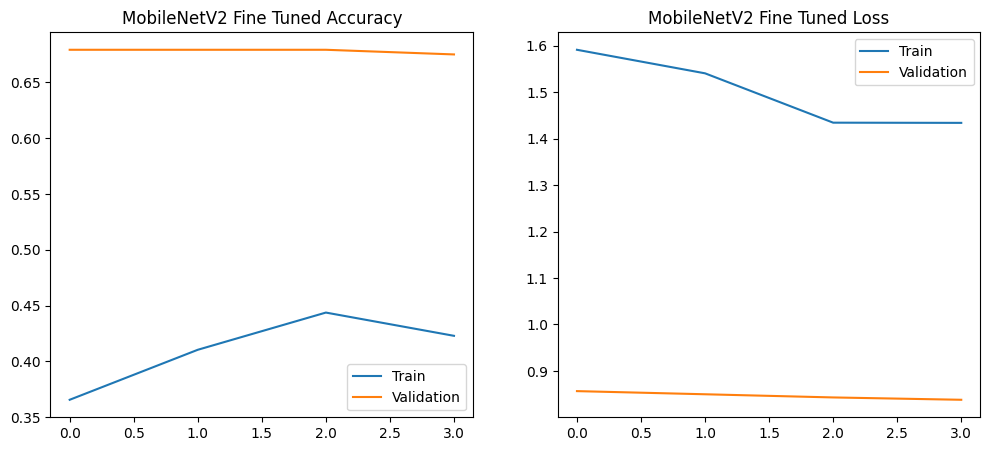

MobileNetV2: 0.6791666746139526
MobileNetV2: 0.4437499940395355


In [ ]:
plot_history(history_finetune, "MobileNetV2 Fine Tuned")

print("MobileNetV2:", max(history_finetune.history['val_accuracy']))
print('MobileNetV2:', max(history_finetune.history['accuracy']))




In [20]:
from tensorflow.keras.models import load_model

model = load_model('MobileNetV2_finetuned.h5')
val_acc = max(history_finetune.history['val_accuracy'])
print("Last recorded best val acc:", val_acc)
loss, acc = model.evaluate(valid_generator)
print("Validation Accuracy (reloaded model):", acc)


Last recorded best val acc: 0.6458333134651184
8/8 [==============================] - 3s 161ms/step - loss: 0.4460 - accuracy: 0.8458
Validation Accuracy (reloaded model): 0.8458333611488342


In [21]:
model.save("MobileNetV2_High_accuracy.h5")


c:\Users\Kanishka\OneDrive\Desktop\AI_DermalScan\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model Training Overview

In this notebook, multiple convolutional neural network (CNN) architectures were explored using
transfer learning to identify the most suitable model for skin condition classification.

The following pretrained models were evaluated:

- **EfficientNetB0**
- **ResNet50**
- **VGG16**
- **MobileNetV2**

Each model was initialized with pretrained ImageNet weights, and a custom classification head
was added for multi-class skin condition prediction. All models were trained using categorical
cross-entropy loss and the Adam optimizer.

Based on comparative evaluation of training and validation performance, **MobileNetV2**
demonstrated better accuracy and consistency. As a result, MobileNetV2 was selected for further
experimentation and was **retrained from scratch in Notebook 2** with minor adjustments to
data augmentation and training parameters to further improve training and validation accuracy.
